In [267]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point
import copy

In [10]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
geodata = geodata[['E09' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)

In [11]:
geodata['centroid'] = geodata.centroid

<AxesSubplot:>

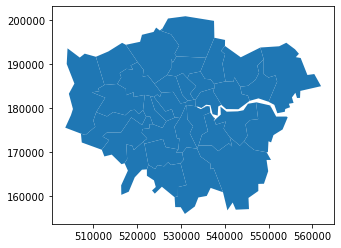

In [12]:
geodata.plot()

In [120]:
neighbours = geodata.sjoin(geodata, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]

In [121]:
def angle_between(loca, locb):
    xa, ya = loca.xy
    xb, yb = locb.xy    
    return np.arctan2(yb[0]-ya[0], xb[0]-xa[0])

neighbours['target_angle'] = neighbours.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'target_angle']]

In [122]:
neighbours

,LAD20CD_left,LAD20CD_right,target_angle
281,E09000001,E09000022,-1.797682
286,E09000006,E09000022,2.514451
288,E09000008,E09000022,1.799088
304,E09000024,E09000022,0.763387
308,E09000028,E09000022,-2.456275
...,...,...,...
306,E09000026,E09000002,-0.806490
304,E09000024,E09000021,-2.769225
307,E09000027,E09000021,-1.256605
309,E09000029,E09000021,2.780267


In [123]:
crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['centroid_left'].distance(row['centroid_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

In [124]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,E09000001,E09000002,21.0,0.237293
2,E09000001,E09000003,18.0,2.207847
3,E09000001,E09000004,24.0,-0.334989
4,E09000001,E09000005,16.0,2.777032
5,E09000001,E09000006,27.0,-0.978932
...,...,...,...,...
1083,E09000033,E09000028,8.0,-0.612246
1084,E09000033,E09000029,25.0,-1.619409
1085,E09000033,E09000030,10.0,0.073124
1086,E09000033,E09000031,18.0,0.751657


In [97]:
# Create an initial grid

initial_scale_factor = 2

full_bounds = geodata.total_bounds
axis_ratio = (full_bounds[3]-full_bounds[1])/(full_bounds[2]-full_bounds[0])
initial_y_length = int(np.round(initial_scale_factor*np.sqrt(len(geodata)/axis_ratio), decimals=0))
initial_x_length = int(np.round(axis_ratio*initial_y_length))

initial_grid = np.meshgrid(range(initial_x_length), range(initial_x_length))
initial_grid_size = initial_y_length*initial_x_length

In [258]:
# Randomly allocate codes to grid locations
codes_list = geodata['LAD20CD'].values
initial_coords = np.unravel_index(random.sample(range(initial_grid_size), len(codes_list)), (initial_x_length, initial_y_length))

# initial_layout = np.zeros((initial_x_length, initial_y_length), dtype=object)

# for code,x,y in zip(codes_list,initial_coords[0],initial_coords[1]):
#     initial_layout[x,y] = code

In [307]:
neighbour_distance_factor = 100
neighbour_angle_factor = 0

proximity_distance_factor = 5
proximity_angle_factor = 0


def generate_geodataframe(codes, coords):
    
    grid_pdf = pd.DataFrame({
        'code': codes,
        'y': coords[0],
        'x': coords[1]
    })
    grid_gdf = gpd.GeoDataFrame(grid_pdf, geometry=gpd.points_from_xy(grid_pdf['x'], grid_pdf['y']))
    grid_gdf.crs = 'epsg:27700'
    
    return grid_gdf[['code', 'geometry']]


def angle_difference(angle1, angle2):
    d = angle2-angle1
    d = d+(2*np.pi) if d < -np.pi else d
    d = d-(2*np.pi) if d > np.pi else d
    return d


def get_metric(it_gdf):
    
    # Find the distances and angles to all the neighbours
    it_neighbours = it_gdf.merge(neighbours, left_on='code', right_on='LAD20CD_left')
    it_neighbours = it_neighbours.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_neighbours = it_neighbours[['code', 'geometry', 'code_r', 'geometry_r', 'target_angle']]

    it_neighbours['distance'] = it_neighbours.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_neighbours['angle'] = it_neighbours.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
    it_neighbours['angle_diff'] = it_neighbours.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)

    # Define the neighbour metric
    it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: (neighbour_distance_factor*row['distance']**2)+(neighbour_angle_factor*row['angle_diff']**2), axis=1)
    neighbour_metric = it_neighbours.groupby('code')['neighbour_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(neighbour_metric, on='code', how='left')
    
    
    # Define the proximity metric
    it_prox = it_gdf.merge(distance_ranking, left_on='code', right_on='LAD20CD_left')
    it_prox = it_prox.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_prox = it_prox[['code', 'geometry', 'code_r', 'geometry_r', 'target_distance_rank', 'target_angle']]
    
    it_prox['distance'] = it_prox.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_prox['distance_rank'] = it_prox.groupby('code')['distance'].rank()
    it_prox['distance_rank_difference'] = it_prox['distance_rank']-it_prox['target_distance_rank']
    it_prox['angle'] = it_prox.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
    it_prox['angle_diff'] = it_prox.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)
    
    it_prox['proximity_metric'] = it_prox.apply(lambda row: (proximity_distance_factor*row['distance_rank_difference']**2)+(proximity_angle_factor*row['angle_diff']**2), axis=1)
    proximity_metric = it_prox.groupby('code')['proximity_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(proximity_metric, on='code', how='left')
    
    it_gdf['metric'] = it_gdf['neighbour_metric']+it_gdf['proximity_metric']
    return it_gdf


def find_it_gdf(codes_list, coords):
    it_gdf = generate_geodataframe(codes_list, coords)
    return get_metric(it_gdf)

def do_swaps(gdf, max_metric):
    
#     max_metric = gdf[gdf['metric']==gdf['metric'].max()]
    
    original_loc = max_metric['geometry'].values[0]
    original_x, original_y = original_loc.xy
    
    directions = []
    metrics = []
    new_dfs = []
    
    for x_shift, EW in zip([-1,0,1], ['W', 'C', 'E']):
        for y_shift, NS in zip([-1,0,1], ['S', 'C', 'N']):
            directions.append(NS+EW)
            new_loc = Point((original_x[0]+x_shift, original_y[0]+y_shift))
            
            new_df = copy.copy(gdf)
            new_df.loc[(gdf['geometry']==new_loc), 'geometry'] = original_loc
            new_df.loc[(gdf['metric']==gdf['metric'].max()), 'geometry'] = new_loc
            
            new_df = get_metric(new_df[['code', 'geometry']])
            new_dfs.append(new_df)
            metrics.append(new_df['metric'].sum())

    dir_to_use = directions[np.argmin(metrics)]    
    return dir_to_use, new_dfs[np.argmin(metrics)]


def do_iteration(gdf):
    
    # THIS IS WHERE I'M WORKING
    # I need to run do_swaps on the dataframe.
    # If there's no change (i.e. d=="CC") then I need to set that row's is_tested to True and run do_swaps again.
    # If I can keep running do_swaps until there's nothing left that can be swapped, we stop.
    
    
    gdf['is_tested'] = [False]*len(gdf)
    
    all_tested = False    
    iterate = True
    
    old_gdf = gdf
    while iterate:    
        max_metric = old_gdf.loc[(old_gdf['is_tested']==False), 'metric'].max()
        row_to_test = old_gdf.loc[old_gdf['metric']==max_metric]
        d, new_gdf = do_swaps(old_gdf, row_to_test)
        
        
        if (d != 'CC') & ()
        
        if d == "CC":
            old_gdf.loc[(old_gdf['metric']==max_metric), 'is_tested'] = True
            num_tested = old_gdf['is_tested'].sum()
            all_tested = True if num_tested == len(old_gdf) else False
        else:
            iterate = False
            old_gdf = new_gdf
            
    return all_tested, new_gdf

In [308]:
initial_gdf = find_it_gdf(codes_list, initial_coords)
d, new_df = do_iteration(initial_gdf)
# s = do_swaps(initial_gdf)
# [s[c].xy for c in s.keys()]
# do_swaps(initial_gdf)['CC'].plot(column='metric')
# do_swaps(initial_gdf)['SW'].plot(column='metric')

In [306]:
gdf = initial_gdf
gdf['is_tested'] = [False]*len(gdf)    
all_tested = False    
iterate = True
old_gdf = gdf

while iterate:    
        max_metric = old_gdf.loc[(old_gdf['is_tested']==False), 'metric'].max()
        row_to_test = old_gdf.loc[old_gdf['metric']==max_metric]
        d, new_gdf = do_swaps(old_gdf, row_to_test)
        
        if d == "CC":
            old_gdf.loc[(old_gdf['metric']==max_metric), 'is_tested'] = True
            num_tested = old_gdf['is_tested'].sum()
            iterate = False if num_tested == len(old_gdf) else True
            all_tested = True if num_tested == len(old_gdf) else False
        else:
            iterate = False

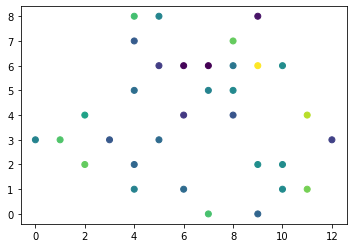

In [305]:
c = 'y'
old_df = initial_gdf
while c == 'y':
    d, new_df = do_iteration(old_df)
    new_df.plot(column='metric')
    plt.show()
    
    c = 'y' if d == True else 'n'
    
    old_df = new_df
    
    

<AxesSubplot:>

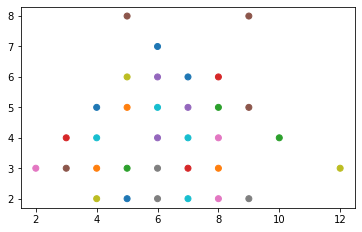

In [291]:
new_df.plot(column='code')

<AxesSubplot:>

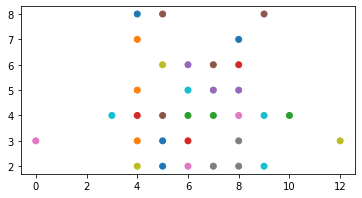

In [284]:
new_df.plot(column='code')

<AxesSubplot:>

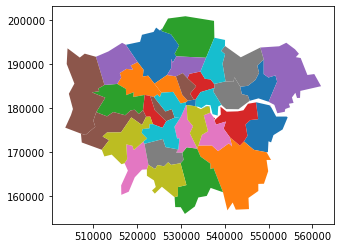

In [279]:
geodata.plot(column='LAD20CD')